In [44]:
import pandas as pd

sample_data = pd.read_csv("/Users/harshbhalwar/Downloads/sample_input.csv")
sample_data.head()

,City,ARSON,ASSAULT,BURGLARY,COUNTERFEITING,CYBERCRIME,DRUG OFFENSE,EXTORTION,FIREARM OFFENSE,FRAUD,ROBBERY,SHOPLIFTING,TRAFFIC VIOLATION,VANDALISM,VEHICLE THEFT,Population,Unemployment Rate,Literacy Rate,Total Crimes
0,Metropolis,10,85,120,5,40,70,3,12,30,25,55,200,35,28,500000,6.5,92.3,718


In [45]:
import joblib

random_forest = joblib.load("random_forest.pkl")
print("Model loaded successfully")

xgModel = joblib.load("xgModel.pkl")

encoder =joblib.load('city_encoder.pkl')

knnModel = joblib.load('knnModel.pkl')

Model loaded successfully


In [46]:
print(sample_data)

         City  ARSON  ASSAULT  BURGLARY  COUNTERFEITING  CYBERCRIME  \
0  Metropolis     10       85       120               5          40   

   DRUG OFFENSE  EXTORTION  FIREARM OFFENSE  FRAUD  ROBBERY  SHOPLIFTING  \
0            70          3               12     30       25           55   

   TRAFFIC VIOLATION  VANDALISM  VEHICLE THEFT  Population  Unemployment Rate  \
0                200         35             28      500000                6.5   

   Literacy Rate  Total Crimes  
0           92.3           718  


In [47]:
# Encode city — this will result in 56 columns as trained
encoded_city = encoder.transform(sample_data[['City']])
encoded_city_df = pd.DataFrame(encoded_city, columns=encoder.get_feature_names_out(['City']))

# Combine with other features
X_new = pd.concat([encoded_city_df, sample_data.drop(['City'], axis=1)], axis=1)

# Ensure all columns match training order
missing_cols = set(random_forest.feature_names_in_) - set(X_new.columns)
for col in missing_cols:
    X_new[col] = 0  # Add missing columns with 0

X_new = X_new[random_forest.feature_names_in_]

In [48]:
# Load feature names
knn_features = joblib.load("knnFeatures.pkl")

X_knn = pd.concat([encoded_city_df, sample_data.drop(['City'], axis=1)], axis=1)

missing_cols1 = set(knn_features) - set(X_knn.columns)
for col in missing_cols1:
    X_knn[col] = 0  # Add missing columns with 0

X_knn = X_knn[knn_features]

In [49]:
pred = random_forest.predict(X_new)

print(pred)

[29.33744186]


In [50]:
pred2 =xgModel.predict(X_new)
print(pred2)

[30.950634]


In [51]:
pred3 = knnModel.predict(X_knn)
print(pred3)

[[28.67113136]]


/Users/harshbhalwar/Documents/python/virtual/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [52]:
knnPrediction = joblib.load("knn_prediction")
print(knnPrediction)

[[33.35111312]
 [25.69217288]
 [32.09124535]
 [27.38136522]
 [38.27890314]
 [30.1321768 ]
 [27.97830935]
 [29.39917366]]


In [53]:
xgBoostPrediction = joblib.load("xgBoost_prediction")

randomForestPrediction = joblib.load("randomForestPrediction")

print(xgBoostPrediction)
print(randomForestPrediction)

[26.225029 26.374075 35.250854 26.178093 30.420849 29.921078 34.574505
 34.196   ]
[23.04203148 25.91900144 36.6679462  22.273389   33.43782284 30.97454863
 34.18435542 34.59214123]


In [54]:
testing_data = joblib.load("testing_data")

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2 Score': abs(r2_score(y_true, y_pred))
    }

metrics_rf = evaluate_model(testing_data, randomForestPrediction)
metrics_xgb = evaluate_model(testing_data, xgBoostPrediction)
metrics_knn = evaluate_model(testing_data, knnPrediction)


In [58]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb,
    'KNN': metrics_knn
}).T  # Transpose for easier plotting

print(comparison_df)


                      MSE       RMSE       MAE  R2 Score
Random Forest   88.158885   9.389296  6.120855  0.447338
XGBoost         99.508783   9.975409  7.132753  0.376186
KNN            181.582436  13.475253  9.291258  0.138328


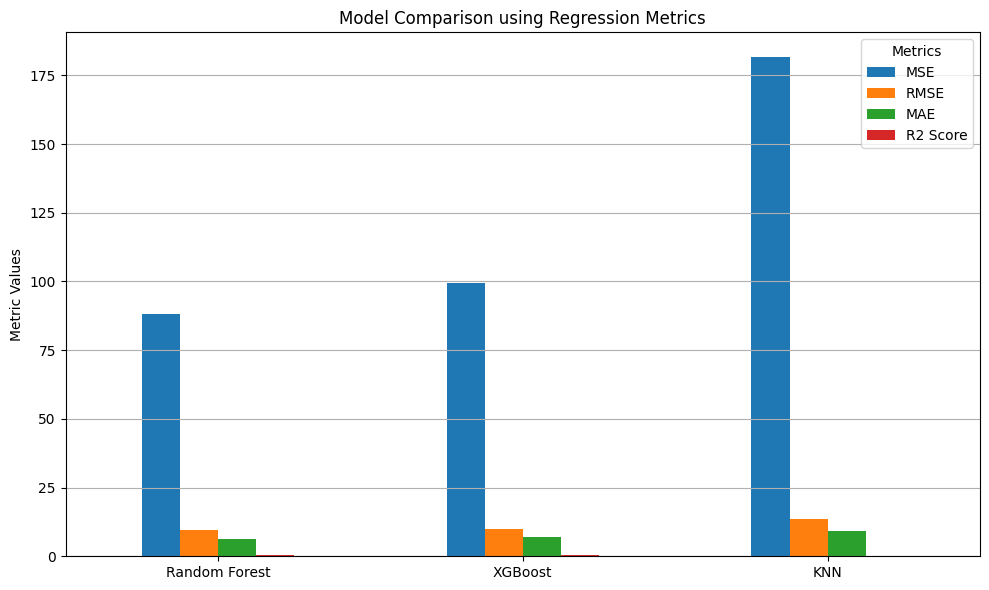

In [59]:
import matplotlib.pyplot as plt

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison using Regression Metrics")
plt.ylabel("Metric Values")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


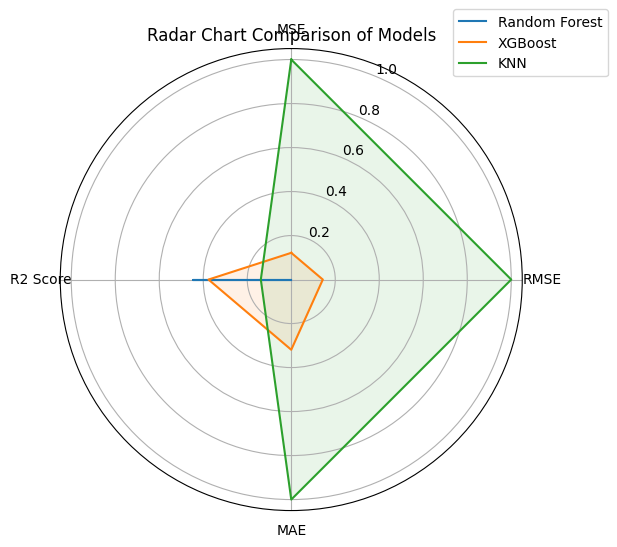

In [60]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize all columns except R2
normalized_df = comparison_df.copy()
scaler = MinMaxScaler()
normalized_df.iloc[:, :-1] = scaler.fit_transform(normalized_df.iloc[:, :-1])

# Radar chart setup
labels = list(normalized_df.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for i, (model_name, row) in enumerate(normalized_df.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=model_name)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar Chart Comparison of Models")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()
